# Ecological Index - longitudinal plots
- Plot "present day" and 2000 ecological index by longitude.
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- October 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# keep and convert tarea to km2 from cm2
tarea = ds_grid.TAREA/((100*100)*(1000*1000))

## Load EcoIndex Data

In [7]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load "Present Day"

In [8]:
file_in = 'ecoindex_present_day.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [9]:
# keep regional version only
eco_pd = ds_eco.ecoindex_regional_noseal

### Load 2000

In [10]:
file_in = 'ecoindex_historical_future.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [11]:
# keep some decades
eco_2000 = ds_eco.ecoindex_regional_decadal.sel(decades=2000)

### Make masks of "very high" and "high" region

- Very high: EI>= 0.8
- High: EI>=0.6 AND EI<0.8
- Moderate: EI>=0.4 AND EI<0.6
- Low: EI<0.4

In [12]:
#eco_bin_names = ['very_high','high','moderate','low']
eco_bin_names = [1,2,3,4]

In [13]:
# combine these into a single array
xlen = len(eco_pd.nlon)
ylen = len(eco_pd.nlat)

In [14]:
# "Present Day" masking
data = eco_pd

# make arrays to fill
eco_1 = data.where(data == 1, other =1)
eco_2 = data.where(data == 1, other =1)
eco_3 = data.where(data == 1, other =1)
eco_4 = data.where(data == 1, other =1)

# now just mask by bin
eco_1 = eco_1.where(data >=0.8)
eco_2 = eco_2.where((data >=0.6) & (data <0.8))
eco_3 = eco_3.where((data >=0.4) & (data <0.6))
eco_4 = eco_4.where(data <0.4)

# convert to single array
eco_bins = np.zeros([4,ylen,xlen])
eco_bins[0,:,:] = eco_1.values
eco_bins[1,:,:] = eco_2.values
eco_bins[2,:,:] = eco_3.values
eco_bins[3,:,:] = eco_4.values

# convert to xarray
eco_bins_pd = xr.DataArray(eco_bins,dims=('bins','nlat','nlon'))
eco_bins_pd['bins'] = eco_bin_names
eco_bins_pd['nlat'] = data.nlat
eco_bins_pd['nlon'] = data.nlon

In [15]:
# 2000 masking
data = eco_2000

# make arrays to fill
eco_1 = data.where(data == 1, other =1)
eco_2 = data.where(data == 1, other =1)
eco_3 = data.where(data == 1, other =1)
eco_4 = data.where(data == 1, other =1)

# now just mask by bin
eco_1 = eco_1.where(data >=0.8)
eco_2 = eco_2.where((data >=0.6) & (data <0.8))
eco_3 = eco_3.where((data >=0.4) & (data <0.6))
eco_4 = eco_4.where(data <0.4)

# convert to single array
eco_bins = np.zeros([4,ylen,xlen])
eco_bins[0,:,:] = eco_1.values
eco_bins[1,:,:] = eco_2.values
eco_bins[2,:,:] = eco_3.values
eco_bins[3,:,:] = eco_4.values

# convert to xarray
eco_bins_2000 = xr.DataArray(eco_bins,dims=('bins','nlat','nlon'))
eco_bins_2000['bins'] = eco_bin_names
eco_bins_2000['nlat'] = data.nlat
eco_bins_2000['nlon'] = data.nlon

## Load Typical polynya data

In [16]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [17]:
# Read in satellite polynya data
file_in = 'CESM_grid_SSMI_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_sat_pd = ds_poly.polynya_typical_all

In [18]:
# Read in jra55 polynya data
file_in = 'CESM_grid_JRA55_hindcast_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_jra_pd = ds_poly.polynya_typical_all_hi

In [19]:
# Read in cesm2-le polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_cesm2le_pd = ds_poly.polynya_typical_all_hi

# keep some decades
poly_2000 = poly_cesm2le_pd.sel(decades=2000)

# reassign coordinates so it'll work later
poly_2000['nlat'] = tarea.nlat
poly_2000['nlon'] = tarea.nlon

## Load SIZ data

In [20]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [21]:
# Read in 2000 data
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_mfdataset(dir_in+file_in,decode_times=False)

# get ensemble mean SIC for september in 2000
sic_2000 = ds_siz.SIC_SEP.mean(dim='member_id').sel(time=2000)
# make array to fill
siz_2000 = sic_2000.where(sic_2000 == 1, other = 1)
# keep only SIZ data
siz_2000 = siz_2000.where(sic_2000 >= 0.15,other=0)
# mask land
siz_2000 = siz_2000.where(ds_grid.REGION_MASK == 1)

## Load map related masks for analysis

In [22]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [23]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPAs, MPA planning areas, AES)
ccamlr_in = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9',
             'Ross_mpa','Weddell_mpa','Ant_Peninsula_mpa','East_Ant_mpa',
             'AES']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod,
                          ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.Ross_mpa, ds_ccamlr.Weddell_mpa,
                          ds_ccamlr.Ant_Peninsula_mpa, ds_ccamlr.East_Ant_mpa,
                          ds_ccamlr.AES],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [24]:
# make a mask of ALL mpas (adopted and proposed)

# first load the masks and fill the missing values with 0
Ross_mpa = ccamlr_masks.sel(region='Ross_mpa').fillna(0)
Wed_mpa = ccamlr_masks.sel(region='Weddell_mpa').fillna(0)
Ant_Pen_mpa = ccamlr_masks.sel(region='Ant_Peninsula_mpa').fillna(0)
East_Ant_mpa = ccamlr_masks.sel(region='East_Ant_mpa').fillna(0)

# now sum all the masks to get all mpas
mpa_all = Ross_mpa + Wed_mpa + Ant_Pen_mpa + East_Ant_mpa
mpa_all = mpa_all.where(ds_grid.REGION_MASK == 1)

## Analysis by longitude

In [25]:
# mask TAREA to be just each ecoindex bin
tarea_eco_bins_pd = tarea.where(eco_bins_pd>0)
tarea_eco_bins_2000 = tarea.where(eco_bins_2000>0)

### Calculate total area fraction for each bin 

In [26]:
# sum over nlat index to get total area per longitude
tot_area_eco_bins_pd = tarea_eco_bins_pd.sum(dim='nlat')
tot_area_eco_bins_2000 = tarea_eco_bins_2000.sum(dim='nlat')

In [27]:
# get the total area per longitude
tot_area_pd = tot_area_eco_bins_pd.sum(dim='bins')
tot_area_2000 = tot_area_eco_bins_2000.sum(dim='bins')

# these should be identical, checked and it was roundoff level differences (10^-11)
#diff = tot_area_pd - tot_area_2000
#diff.plot()

In [28]:
# calculate fraction of total area each ecoindex type
frac_eco_bins_pd = tot_area_eco_bins_pd/tot_area_pd
frac_eco_bins_2000 = tot_area_eco_bins_2000/tot_area_2000

# check the sum because fraction of all bins together should equal 1
#frac_eco_bins_pd.sum(dim='bins').plot()
#frac_eco_bins_2000.sum(dim='bins').plot()

### Calculate total polynya fraction for each bin 

In [29]:
# calculate total polynya area by longitude
tot_area_poly_pd = tarea.where(poly_sat_pd>0).sum(dim='nlat')
tot_area_poly_2000 = tarea.where(poly_2000>0).sum(dim='nlat')

In [30]:
# slightly adjust the total area so that we don't divide by zero
tot_area_poly_pd = tot_area_poly_pd + 1
tot_area_poly_2000 = tot_area_poly_2000 + 1

In [31]:
# find points that are both in the eco bins AND polynyas
tarea_eco_bins_poly_pd = tarea.where((eco_bins_pd>0) & (poly_sat_pd>0))
tarea_eco_bins_poly_2000 = tarea.where((eco_bins_2000>0) & (poly_2000>0))

In [32]:
# sum over nlat index to get total area per longitude
tot_area_poly_eco_bins_pd = tarea_eco_bins_poly_pd.sum(dim='nlat')
tot_area_poly_eco_bins_2000 = tarea_eco_bins_poly_2000.sum(dim='nlat')

In [33]:
# calculate fraction of polynya area for each ecoindex type
frac_poly_pd = tot_area_poly_eco_bins_pd/tot_area_poly_pd
frac_poly_2000 = tot_area_poly_eco_bins_2000/tot_area_poly_2000

# check the sum because fraction of all bins together should equal 1 in polynyas
#frac_poly_pd.sum(dim='bins').plot()
#frac_poly_2000.sum(dim='bins').plot()

## Adjust the fields so that they start at Longitude 0 and end at 360

- Also transpose so they'll plot properly
- frac_eco_bins_new.transpose('bins','nlon')

In [34]:
# get dimensions of the grid
xlen = len(ds_grid.nlon)
ylen = len(ds_grid.nlat)
blen = len(eco_bin_names)

In [35]:
# check original longitudes
lons = ds_grid.TLONG.isel(nlat=0)
#lons.values
#lons.values[36]
#lons.plot()

In [36]:
# create a new 1d longitude array
lons_new = np.zeros([xlen])
lons_new[0:284] = lons[36:320].values
lons_new[284:320] = lons[0:36].values

# convert to xarray
lons_new = xr.DataArray(lons_new,dims='nlon')
lons_new['nlon'] = lons.nlon

#lons_new.plot()

In [37]:
# create a new 2d latitude array
lat2d = ds_grid.TLAT

lat2d_new = np.zeros([ylen,xlen])
lat2d_new[:,0:284] = lat2d[:,36:320].values
lat2d_new[:,284:320] = lat2d[:,0:36].values

# convert to xarray
lat2d_new = xr.DataArray(lat2d_new,dims=('nlat','nlon'))
lat2d_new['nlat'] = ds_grid.nlat
lat2d_new['nlon'] = lons_new.nlon.values

In [38]:
# create a new 2d longitude array
lon2d = ds_grid.TLONG

lon2d_new = np.zeros([ylen,xlen])
lon2d_new[:,0:284] = lon2d[:,36:320].values
lon2d_new[:,284:320] = lon2d[:,0:36].values

# convert to xarray
lon2d_new = xr.DataArray(lon2d_new,dims=('nlat','nlon'))
lon2d_new['nlat'] = ds_grid.nlat
lon2d_new['nlon'] = lons_new.nlon.values

### Adjust SIZ mask

In [39]:
# create a new polynya mask
siz_2000_new = np.zeros([ylen,xlen])
siz_2000_new[:,0:284] = siz_2000[:,36:320].values
siz_2000_new[:,284:320] = siz_2000[:,0:36].values

# convert to xarray
siz_2000_new = xr.DataArray(siz_2000_new,dims=('nlat','nlon'))
siz_2000_new['nlat'] = siz_2000.nlat
siz_2000_new['nlon'] = lons_new.nlon.values

### Adjust bin total areas

In [40]:
# create a new fraction of ecoindex bin array
frac_eco_bins_pd_new = np.zeros([xlen,blen])
frac_eco_bins_pd_new[0:284,:] = frac_eco_bins_pd[36:320,:].values
frac_eco_bins_pd_new[284:320,:] = frac_eco_bins_pd[0:36,:].values

# convert to xarray
frac_eco_bins_pd_new = xr.DataArray(frac_eco_bins_pd_new,dims=('nlon','bins'))
frac_eco_bins_pd_new['nlon'] = lons_new.nlon
frac_eco_bins_pd_new['bins'] = eco_bin_names

In [41]:
# create a new fraction of ecoindex bin array
frac_eco_bins_2000_new = np.zeros([xlen,blen])
frac_eco_bins_2000_new[0:284,:] = frac_eco_bins_2000[36:320,:].values
frac_eco_bins_2000_new[284:320,:] = frac_eco_bins_2000[0:36,:].values

# convert to xarray
frac_eco_bins_2000_new = xr.DataArray(frac_eco_bins_2000_new,dims=('nlon','bins'))
frac_eco_bins_2000_new['nlon'] = lons_new.nlon
frac_eco_bins_2000_new['bins'] = eco_bin_names

### Adjust polynya data

In [42]:
# create a new polynya mask
poly_pd_new = np.zeros([ylen,xlen])
poly_pd_new[:,0:284] = poly_sat_pd[:,36:320].values
poly_pd_new[:,284:320] = poly_sat_pd[:,0:36].values

# convert to xarray
poly_pd_new = xr.DataArray(poly_pd_new,dims=('nlat','nlon'))
poly_pd_new['nlat'] = poly_sat_pd.nlat
poly_pd_new['nlon'] = lons_new.nlon.values

In [43]:
# create a new polynya mask
poly_2000_new = np.zeros([ylen,xlen])
poly_2000_new[:,0:284] = poly_2000[:,36:320].values
poly_2000_new[:,284:320] = poly_2000[:,0:36].values

# convert to xarray
poly_2000_new = xr.DataArray(poly_2000_new,dims=('nlat','nlon'))
poly_2000_new['nlat'] = poly_2000.nlat
poly_2000_new['nlon'] = lons_new.nlon.values

In [44]:
# create a new fraction of ecoindex bin array
frac_poly_pd_new = np.zeros([xlen,blen])
frac_poly_pd_new[0:284,:] = frac_poly_pd[36:320,:].values
frac_poly_pd_new[284:320,:] = frac_poly_pd[0:36,:].values

# convert to xarray
frac_poly_pd_new = xr.DataArray(frac_poly_pd_new,dims=('nlon','bins'))
frac_poly_pd_new['nlon'] = lons_new.nlon
frac_poly_pd_new['bins'] = eco_bin_names

In [45]:
# create a new fraction of ecoindex bin array
frac_poly_2000_new = np.zeros([xlen,blen])
frac_poly_2000_new[0:284,:] = frac_poly_2000[36:320,:].values
frac_poly_2000_new[284:320,:] = frac_poly_2000[0:36,:].values

# convert to xarray
frac_poly_2000_new = xr.DataArray(frac_poly_2000_new,dims=('nlon','bins'))
frac_poly_2000_new['nlon'] = lons_new.nlon
frac_poly_2000_new['bins'] = eco_bin_names

## Plot the results

- Want to have a plot of contours by bin and longitude with antarctic coastline at the bottom. 

In [73]:
# set some plotting information

# labels for longitude
lon_labels = np.zeros([6])
i = 0
for low_lon in np.arange(0,360,60):
    lon_labels[i] = low_lon   
    i =i + 1

In [74]:
# set labels for y axis
y_label_1 = [0,20,40,60,80,100]
y_label_2 = [0, 50, 100]
#y_label_1 = [0.0,0.2,0.4,0.6,0.8,1.0]
#y_label_2 = [0.0, 0.5, 1.0]

In [75]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'

In [76]:
# set colors
color1 = 'lightblue'
color2 = 'steelblue'     
color3 = 'salmon'
color4 = 'firebrick'

In [77]:
# set levels
cmap_in = 'BuPu' #'Blues'
vmin_in = -1
vmax_in = 2

cmap_in_2 = 'YlOrBr' #'Oranges'
vmin_in_2 = -1
vmax_in_2 = 5

### Plot total area fraction - 2000s
- convert to %

In [78]:
fout = 'Figure_2_Ecoindex_lon_total_area_2000'
# get data to plot
data_bins = frac_eco_bins_2000_new
data_ctr_1 = siz_2000_new
data_ctr_2 = poly_2000_new
label = 'Percent of\nTotal Area'

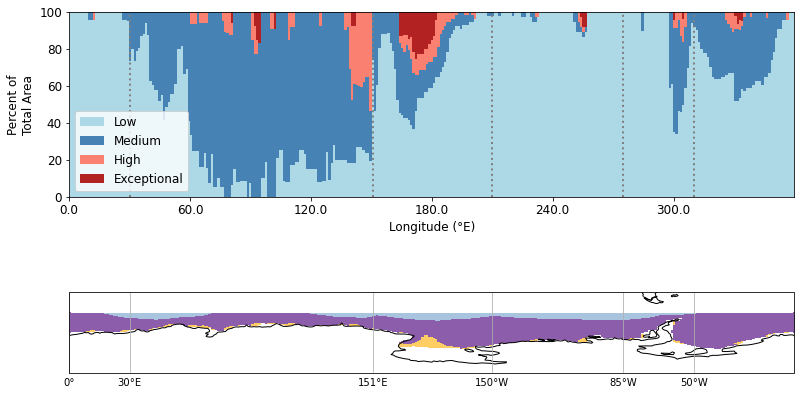

In [79]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_gridspec(6, 8)

ww = 1.15

### plot of the percent by longitude
ax1 = fig.add_subplot(ax[0:3,0:8])
# plot the bins as an stacked bar plot
data1 = data_bins.isel(bins=3)*100.0
pc=ax1.bar(lons_new,data1, width=ww, color=color1,label='Low')
data2 = data_bins.isel(bins=2)*100.0
pc=ax1.bar(lons_new,data2, width=ww, bottom=data1, color=color2,label='Medium')
data3 = data_bins.isel(bins=1)*100.0
pc=ax1.bar(lons_new,data3, width=ww, bottom=data1+data2, color=color3,label='High')
data4 = data_bins.isel(bins=0)*100.0
pc=ax1.bar(lons_new,data4, width=ww, bottom=data1+data2+data3, color=color4,label='Exceptional')

# set tick locations and labels
ax1.set_ylabel(label, fontsize=12)
ax1.set_yticks(y_label_1)
ax1.set_yticklabels(y_label_1,fontsize=12)
ax1.set_xlabel('Longitude (°E)', fontsize=12)
ax1.set_xticks(lon_labels)
ax1.set_xticklabels(lon_labels, fontsize=12)
ax1.xaxis.set_label_position('bottom')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlim([0, 360])
# add lines to show regions
ax1.axvline(x = 30, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 151, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 210, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 275, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 310, color = 'grey',linewidth=2,linestyle=':')
# add legend
ax1.legend(loc='lower left', fontsize=12);

### plot of little map along the bottom
ax2 = fig.add_subplot(ax[4:6,0:8], projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([-179.9, 179.9,-90, -50], ccrs.PlateCarree())
ax2.coastlines('110m',linewidth=1)
# plot SIZ
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_1)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in,vmin=vmin_in,vmax=vmax_in,transform=ccrs.PlateCarree())
# plot polynyas
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_2)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in_2,vmin=vmin_in_2,vmax=vmax_in_2,transform=ccrs.PlateCarree())
# add final map edits
gl = ax2.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([0, 30,151, -150, -85, -50])

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=400)

### Plot polynya area fraction - 2000s

In [80]:
fout = 'Figure_2_Ecoindex_lon_polynya_area_2000'
# get data to plot
data_bins = frac_poly_2000_new
data_ctr_1 = siz_2000_new
data_ctr_2 = poly_2000_new
label = 'Percent of\nPolynya Area'

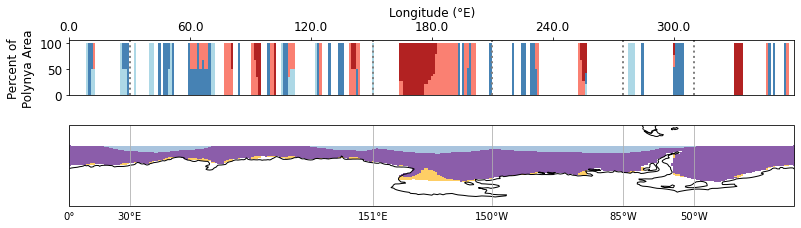

In [81]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_gridspec(6, 8)

ww = 1.15

### plot of the fraction by longitude
ax1 = fig.add_subplot(ax[0:1,0:8])
# plot the bins as an stacked bar plot
data1 = data_bins.isel(bins=3)*100.0
pc=ax1.bar(lons_new,data1, width=ww, color=color1,label='Low')
data2 = data_bins.isel(bins=2)*100.0
pc=ax1.bar(lons_new,data2, width=ww, bottom=data1, color=color2,label='Medium')
data3 = data_bins.isel(bins=1)*100.0
pc=ax1.bar(lons_new,data3, width=ww, bottom=data1+data2, color=color3,label='High')
data4 = data_bins.isel(bins=0)*100.0
pc=ax1.bar(lons_new,data4, width=ww, bottom=data1+data2+data3, color=color4,label='Exceptional')

# set tick locations and labels
ax1.set_ylabel(label, fontsize=12)
ax1.set_yticks(y_label_2)
ax1.set_yticklabels(y_label_2,fontsize=12)
ax1.set_xlabel('Longitude (°E)', fontsize=12)
ax1.set_xticks(lon_labels)
ax1.set_xticklabels(lon_labels, fontsize=12)
ax1.set_xlim([0, 360])
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')
# add lines to show regions
ax1.axvline(x = 30, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 151, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 210, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 275, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 310, color = 'grey',linewidth=2,linestyle=':')
# add legend
#ax1.legend(loc='lower left', fontsize=10);

### plot of little map along the bottom
ax2 = fig.add_subplot(ax[1:3,0:8], projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([-179.9, 179.9,-90, -50], ccrs.PlateCarree())
ax2.coastlines('110m',linewidth=1)
# plot SIZ
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_1)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in,vmin=vmin_in,vmax=vmax_in,transform=ccrs.PlateCarree())
# plot polynyas
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_2)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in_2,vmin=vmin_in_2,vmax=vmax_in_2,transform=ccrs.PlateCarree())
# add final map edits
gl = ax2.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([0, 30,151, -150, -85, -50])

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=400)

## Supplementary Figures

### Plot total area fraction - present day

In [82]:
fout = 'Fig_2_supp_Ecoindex_lon_total_area_present'
# get data to plot
data_bins = frac_eco_bins_pd_new
data_ctr_1 = siz_2000_new
data_ctr_2 = poly_pd_new
label = 'Percent of\nTotal Area'

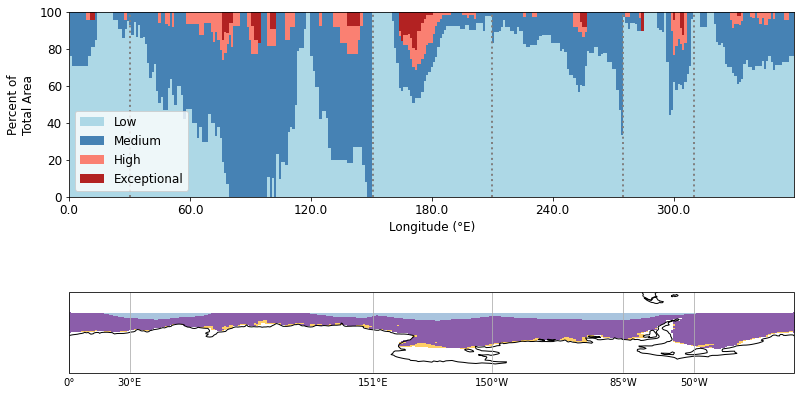

In [83]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_gridspec(6, 8)

ww = 1.15

### plot of the fraction by longitude
ax1 = fig.add_subplot(ax[0:3,0:8])
# plot the bins as an stacked bar plot
data1 = data_bins.isel(bins=3)*100.0
pc=ax1.bar(lons_new,data1, width=ww, color=color1,label='Low')
data2 = data_bins.isel(bins=2)*100.0
pc=ax1.bar(lons_new,data2, width=ww, bottom=data1, color=color2,label='Medium')
data3 = data_bins.isel(bins=1)*100.0
pc=ax1.bar(lons_new,data3, width=ww, bottom=data1+data2, color=color3,label='High')
data4 = data_bins.isel(bins=0)*100.0
pc=ax1.bar(lons_new,data4, width=ww, bottom=data1+data2+data3, color=color4,label='Exceptional')

# set tick locations and labels
ax1.set_ylabel(label, fontsize=12)
ax1.set_yticks(y_label_1)
ax1.set_yticklabels(y_label_1,fontsize=12)
ax1.set_xlabel('Longitude (°E)', fontsize=12)
ax1.set_xticks(lon_labels)
ax1.set_xticklabels(lon_labels, fontsize=12)
ax1.xaxis.set_label_position('bottom')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_xlim([0, 360])
# add lines to show regions
ax1.axvline(x = 30, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 151, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 210, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 275, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 310, color = 'grey',linewidth=2,linestyle=':')
# add legend
ax1.legend(loc='lower left', fontsize=12);

### plot of little map along the bottom
ax2 = fig.add_subplot(ax[4:6,0:8], projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([-179.9, 179.9,-90, -50], ccrs.PlateCarree())
ax2.coastlines('110m',linewidth=1)
# plot SIZ
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_1)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in,vmin=vmin_in,vmax=vmax_in,transform=ccrs.PlateCarree())
# plot polynyas
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_2)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in_2,vmin=vmin_in_2,vmax=vmax_in_2,transform=ccrs.PlateCarree())
# add final map edits
gl = ax2.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([0, 30,151, -150, -85, -50])

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=400)

### Plot polynya area fraction - present day

In [84]:
fout = 'Fig_2_supp_Ecoindex_lon_polynya_area_present'
# get data to plot
data_bins = frac_poly_pd_new
data_ctr_1 = siz_2000_new
data_ctr_2 = poly_pd_new
label = 'Percent of\nPolynya Area'

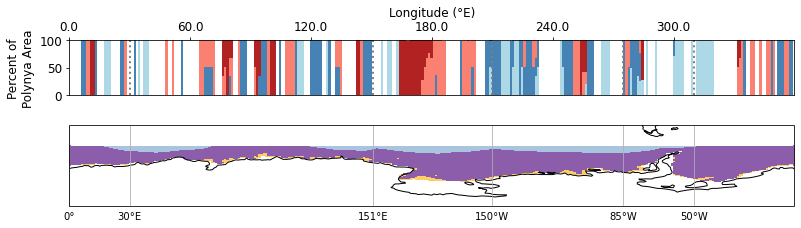

In [85]:
fig = plt.figure(figsize=(13,7))
ax = fig.add_gridspec(6, 8)

ww = 1.15

### plot of the fraction by longitude
ax1 = fig.add_subplot(ax[0:1,0:8])
# plot the bins as an stacked bar plot
data1 = data_bins.isel(bins=3)*100.0
pc=ax1.bar(lons_new,data1, width=ww, color=color1,label='Low')
data2 = data_bins.isel(bins=2)*100.0
pc=ax1.bar(lons_new,data2, width=ww, bottom=data1, color=color2,label='Medium')
data3 = data_bins.isel(bins=1)*100.0
pc=ax1.bar(lons_new,data3, width=ww, bottom=data1+data2, color=color3,label='High')
data4 = data_bins.isel(bins=0)*100.0
pc=ax1.bar(lons_new,data4, width=ww, bottom=data1+data2+data3, color=color4,label='Exceptional')

# set tick locations and labels
ax1.set_ylabel(label, fontsize=12)
ax1.set_yticks(y_label_2)
ax1.set_yticklabels(y_label_2,fontsize=12)
ax1.set_xlabel('Longitude (°E)', fontsize=12)
ax1.set_xticks(lon_labels)
ax1.set_xticklabels(lon_labels, fontsize=12)
ax1.set_xlim([0, 360])
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')
# add lines to show regions
ax1.axvline(x = 30, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 151, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 210, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 275, color = 'grey',linewidth=2,linestyle=':')
ax1.axvline(x = 310, color = 'grey',linewidth=2,linestyle=':')
# add legend
#ax1.legend(loc='lower left', fontsize=10);

### plot of little map along the bottom
ax2 = fig.add_subplot(ax[1:3,0:8], projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([-179.9, 179.9,-90, -50], ccrs.PlateCarree())
ax2.coastlines('110m',linewidth=1)
# plot SIZ
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_1)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in,vmin=vmin_in,vmax=vmax_in,transform=ccrs.PlateCarree())
# plot polynyas
lon, lat, field = utils.adjust_pop_grid(lon2d_new, lat2d_new, data_ctr_2)
ice=ax2.pcolormesh(lon, lat, field, cmap=cmap_in_2,vmin=vmin_in_2,vmax=vmax_in_2,transform=ccrs.PlateCarree())
# add final map edits
gl = ax2.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([0, 30,151, -150, -85, -50])

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=400)